In [1]:
catName = 'low'

In [2]:
import sys, os, pickle, time, re
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from array import array

import ROOT as rt
rt.TGaxis.SetMaxDigits(4)
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import ROOT.RooFit as rf
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, getEff
from histo_utilities import create_TH1D, create_TH2D, SetMaxToMaxHist
from gridVarQ2Plot import col_dic, label_dic
from progressBar import ProgressBar
from categoriesDef import categories

from lumi_utilities import getLumiByTrigger

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1


CMS_lumi.extraText = 5*' ' + 'Internal'

donotdelete = []

In [4]:
m_pi = 0.13957062
m_K = 0.493677
m_D0 = 1.86483
m_Dst = 2.01026
dm = m_Dst - m_D0

In [5]:
catText = rt.TLatex()
catText.SetTextAlign(31)
catText.SetTextSize(0.06)
catText.SetTextFont(42)
catText.SetTextSize(0.05)

In [6]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [7]:
df = pd.DataFrame(rtnp.root2array('../data/cmsRD/skimmed/B2DstMu_200327_Low.root'))

In [8]:
loc = '../data/cmsMC_private/'
loc += 'BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/'
loc += 'ntuples_B2DstMu/skimmed/Low.root'
df_MC = pd.DataFrame(rtnp.root2array(loc))

In [9]:
'  '.join(df.columns)

'index  q2  Est_mu  M2_miss  mu_pt  mu_eta  mu_phi  mu_sigdxy  B_pt  B_eta  B_phi  Dst_pt  Dst_eta  Dst_phi  D0_pt  D0_eta  D0_phi  pi_pt  pi_eta  pi_phi  pi_IP  K_pt  K_eta  K_phi  K_IP  pval_piK  sigdxy_vtxD0_PV  pis_pt  pis_eta  pis_phi  pis_IP  pval_D0pis  mass_piK  mass_D0pis  mass_D0pismu  pval_D0pismu  cos_D0pismu_PV  cosT_D0pismu_PV  N_lowMassAddTks  tkMassHad_0  tkMassHad_1  tkMassMuTk_0  tkMassMuTk_1  tkPt_0  tkPt_1  cat_low  cat_mid  cat_high  N_vtx'

In [10]:
dataDir = '../data/cmsRD'
datasets_loc = glob(dataDir + '/ParkingBPH*/*2018*B2DstMu_200327*')
lumi_tot = getLumiByTrigger(datasets_loc, categories[catName].trg, verbose=True)
CMS_lumi.integrated_lumi = lumi_tot

Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200327
HLT_Mu7_IP4_part2_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200327
HLT_Mu7_IP4_part1_v2 1.24
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200327
HLT_Mu7_IP4_part4_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200327
HLT_Mu7_IP4_part3_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200327
HLT_Mu7_IP4_part0_v2 1.27
Total lumi: 6.35 fb^-1


# General plots

In [139]:
def drawVar(var, binning, xtitle, weights=None, legLoc=[0.18, 0.7, 0.4, 0.93]):
    if isinstance(var, str):
        xRD = df[var]
        xMC = df_MC[var]
    else:
        xRD = var[0]
        xMC = var[1]
    leg = rt.TLegend(legLoc[0], legLoc[1], legLoc[2], legLoc[3])
    leg.SetBorderSize(0)
    leg.SetFillStyle(0)
    
    h = create_TH1D(xRD, 
                    binning=binning, 
                    axis_title=[xtitle, 'Normalized candidates'],
                    scale_histo='norm',
                    opt='overflow+underflow'
                   )
    leg.AddEntry(h, 'data', 'lep')

    h_MC = create_TH1D(xMC, 'bare', binning=h.binning,
                       opt='overflow+underflow',
                       scale_histo='norm')
    h_MC.SetLineColor(col_dic['mu'])
    leg.AddEntry(h_MC, label_dic['mu'], 'lep')
    h_list = [h, h_MC]
    
    if not weights is None:
        h_MC = create_TH1D(xMC, 'weighted', binning=h.binning, 
                           scale_histo='norm',
                           opt='overflow+underflow',
                           weights=weights)
        h_MC.SetLineColor(2)
        h_list.append(h_MC)
        leg.AddEntry(h_MC, 'Weighted '+label_dic['mu'], 'lep')
        
    
    SetMaxToMaxHist(h_list)
    c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
    leg.Draw()
    catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
    c.dnd = h_list + [leg]
    return c

# D0 observables

In [125]:
dM = df['mass_D0pis'] - df['mass_piK']
dM_MC = df_MC['mass_D0pis'] - df_MC['mass_piK']

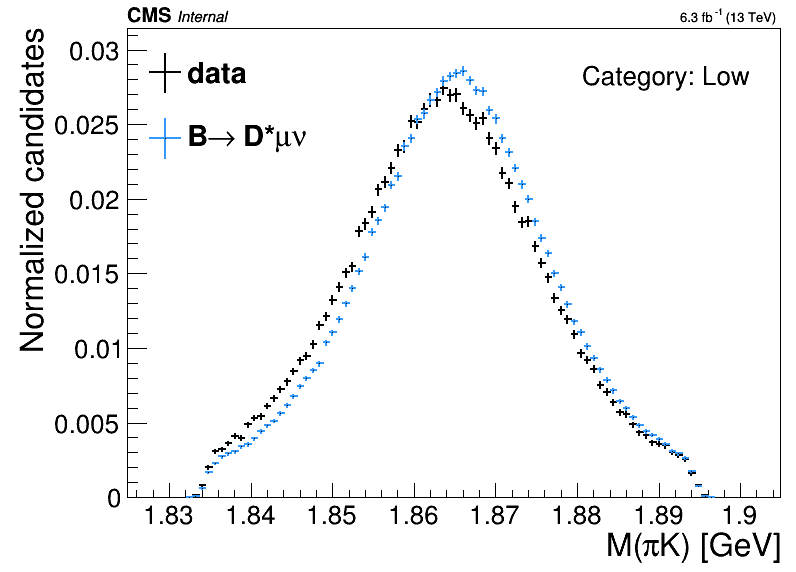

In [126]:
C = drawVar('mass_piK', [100, m_D0-0.04, m_D0+0.04], 'M(#piK) [GeV]')

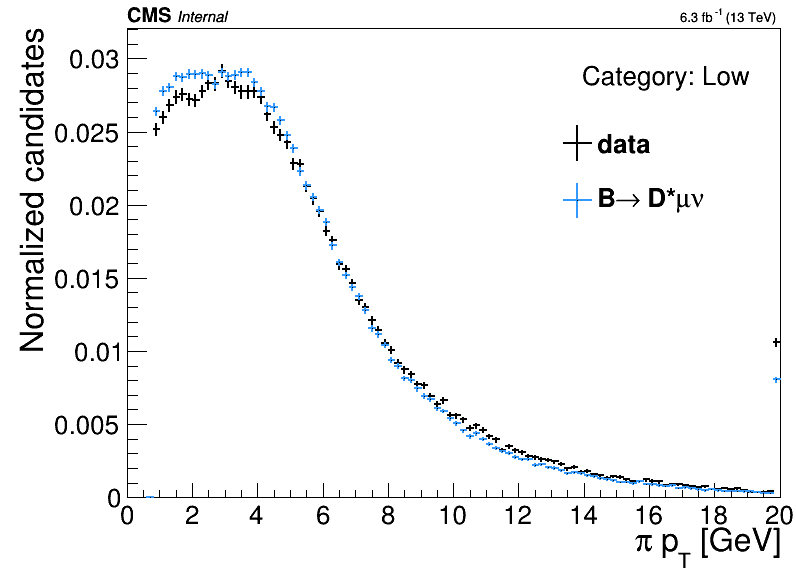

In [129]:
C = drawVar('pi_pt', [100, 0, 20], '#pi p_{T} [GeV]', legLoc=[0.7, 0.6, 0.9, 0.8])

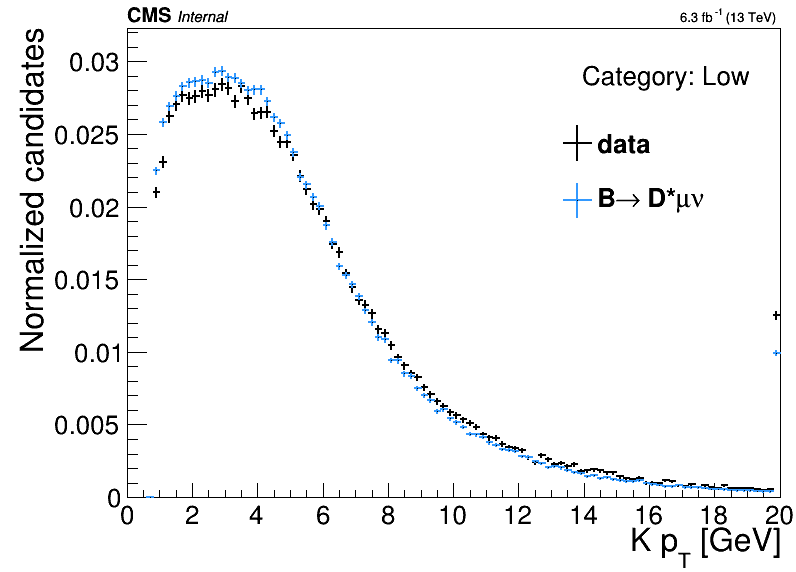

In [130]:
C = drawVar('K_pt', [100, 0, 20], 'K p_{T} [GeV]', legLoc=[0.7, 0.6, 0.9, 0.8])

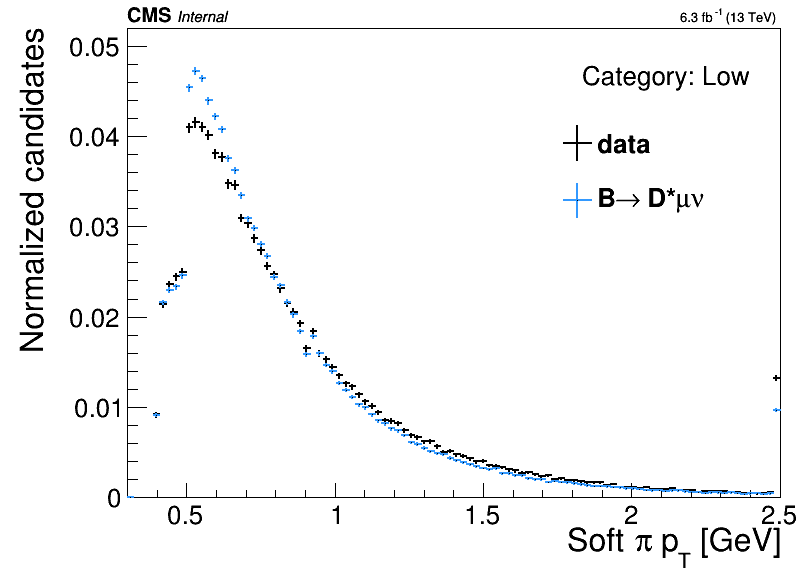

In [175]:
C = drawVar('pis_pt', [100, 0.3, 2.5], 'Soft #pi p_{T} [GeV]', legLoc=[0.7, 0.6, 0.9, 0.8])

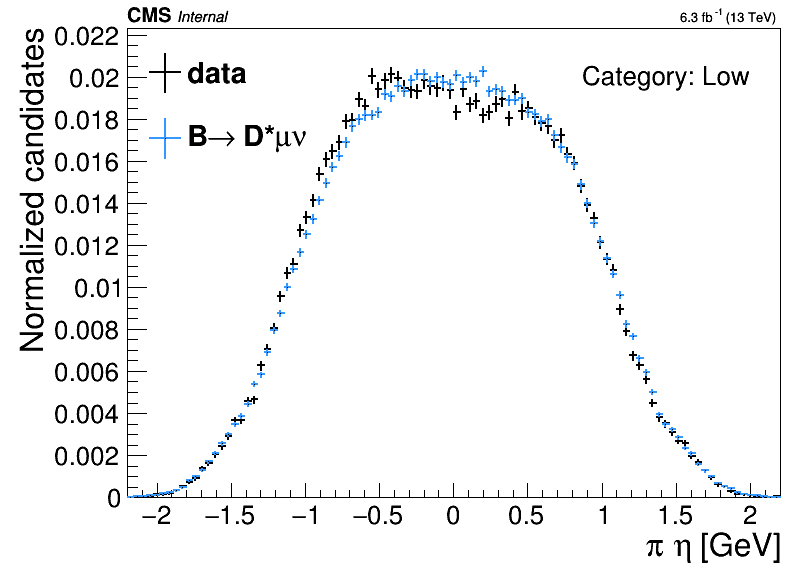

In [131]:
C = drawVar('pi_eta', [100, -2.2, 2.2], '#pi #eta [GeV]')

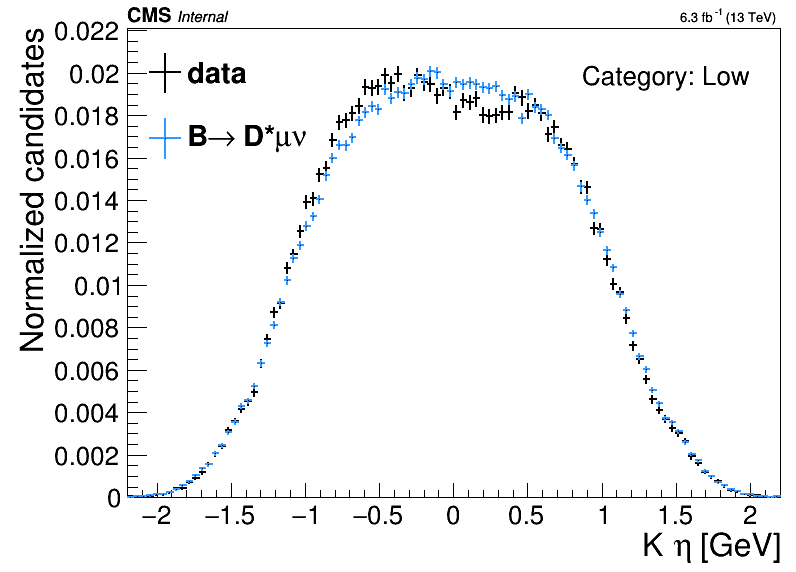

In [132]:
C = drawVar('K_eta', [100, -2.2, 2.2], 'K #eta [GeV]')

### Check if efficiency has effects

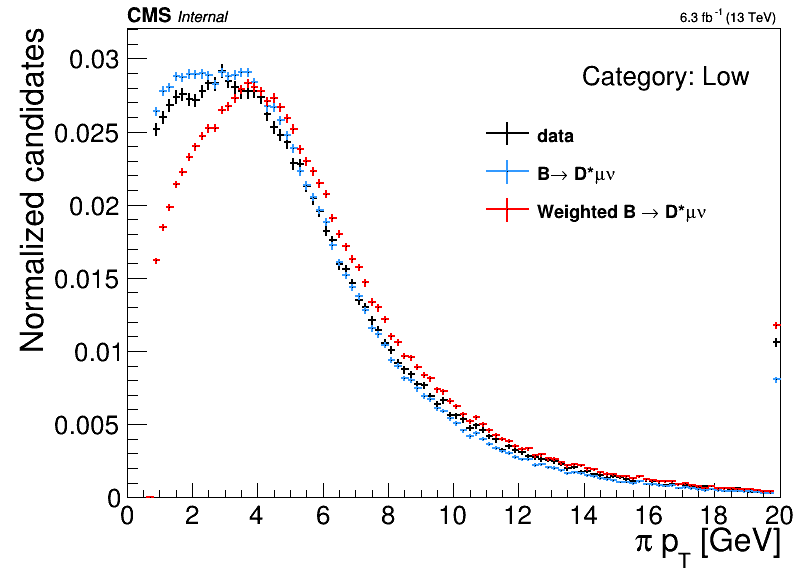

In [146]:
wPi = 1 + 0.4*np.log(df_MC['pi_pt'])
C = drawVar('pi_pt', [100, 0, 20], '#pi p_{T} [GeV]', weights=wPi, legLoc=[0.6, 0.6, 0.9, 0.8])

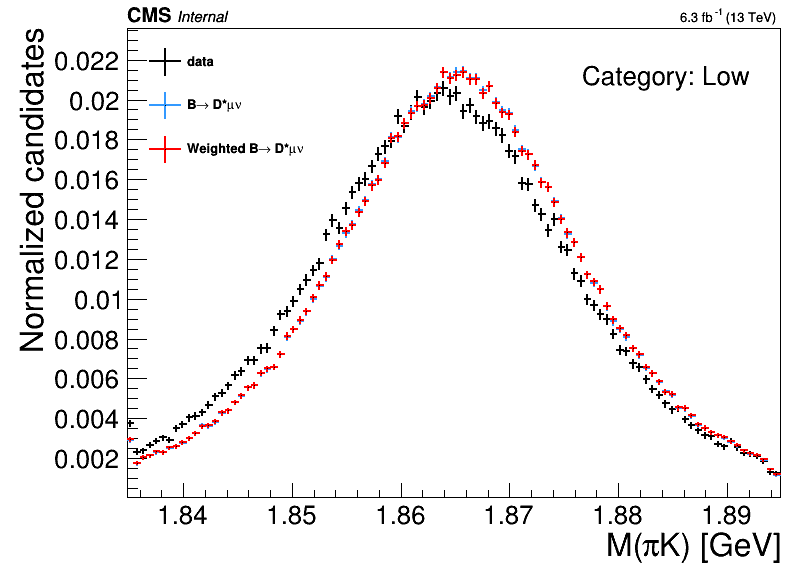

In [147]:
wPi = 1 + 0.4*np.log(df_MC['pi_pt'])
wK = 1 + 0.4*np.log(df_MC['K_pt'])
C = drawVar('mass_piK', [100, m_D0-0.03, m_D0+0.03], 'M(#piK) [GeV]', weights=wPi*wK)

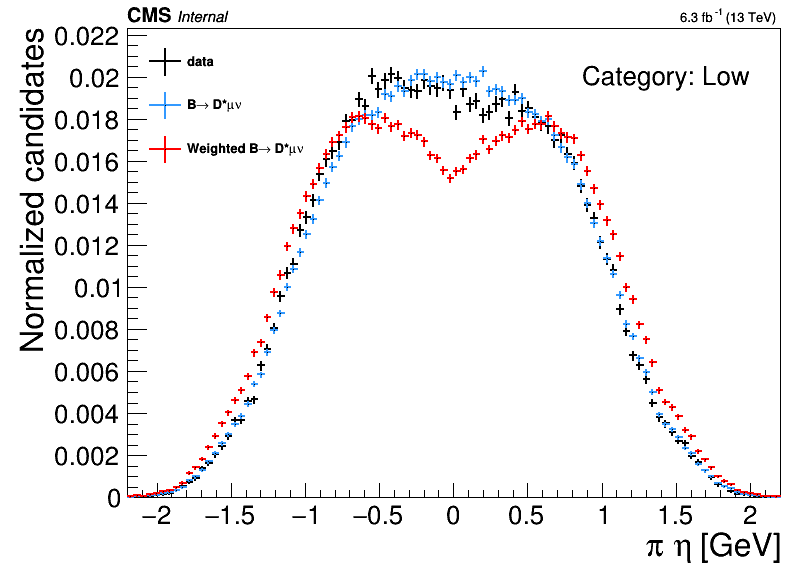

In [148]:
wPi = 1 + 0.5*np.abs(df_MC['pi_eta'])
C = drawVar('pi_eta', [100, -2.2, 2.2], '#pi #eta [GeV]', weights=wPi)

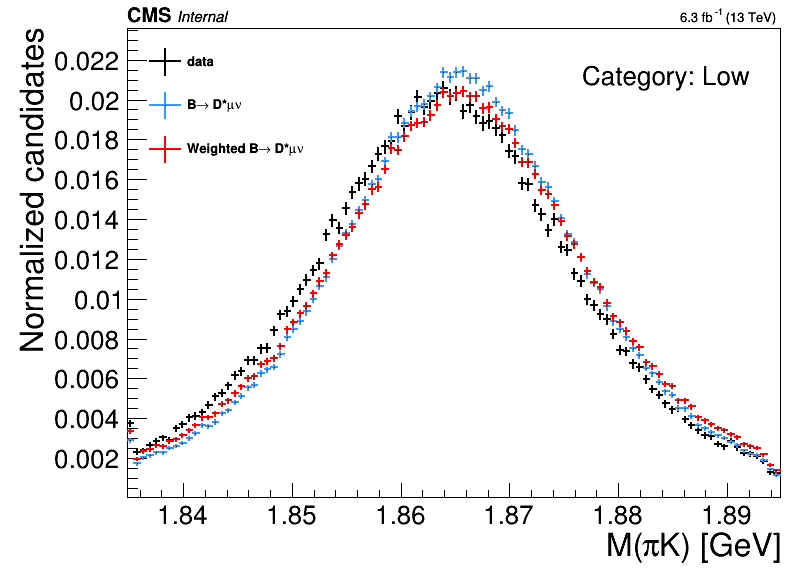

In [149]:
wPi = 1 + 0.4*np.abs(df_MC['pi_eta'])
wK = 1 + 0.4*np.abs(df_MC['K_eta'])
C = drawVar('mass_piK', [100, m_D0-0.03, m_D0+0.03], 'M(#piK) [GeV]', weights=wPi*wK)

### Mass in different regions of $\beta$

<ROOT.TLine object ("TLine") at 0xd319230>

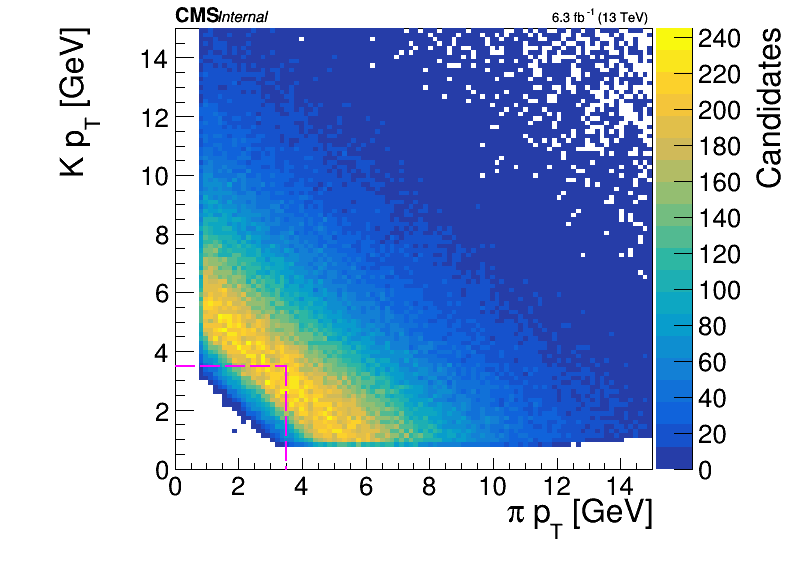

In [114]:
x = np.column_stack((df_MC['pi_pt'], df_MC['K_pt']))
h2 = create_TH2D(x, name='h_pt',
                 binning=[100,0,15,100,0,15],
                 axis_title=['#pi p_{T} [GeV]', 'K p_{T} [GeV]', 'Candidates']
                )
CC = drawOnCMSCanvas(CMS_lumi, [h2], ['colz'], tag='tl', mL=0.22, mR=0.18, mB=0.18)
cPi = 3.5
cK = 3.5
cl.DrawLine(0,cK,cPi,cK)
cl.DrawLine(cPi,0,cPi,cK)

<ROOT.TLine object ("TLine") at 0xb341a40>

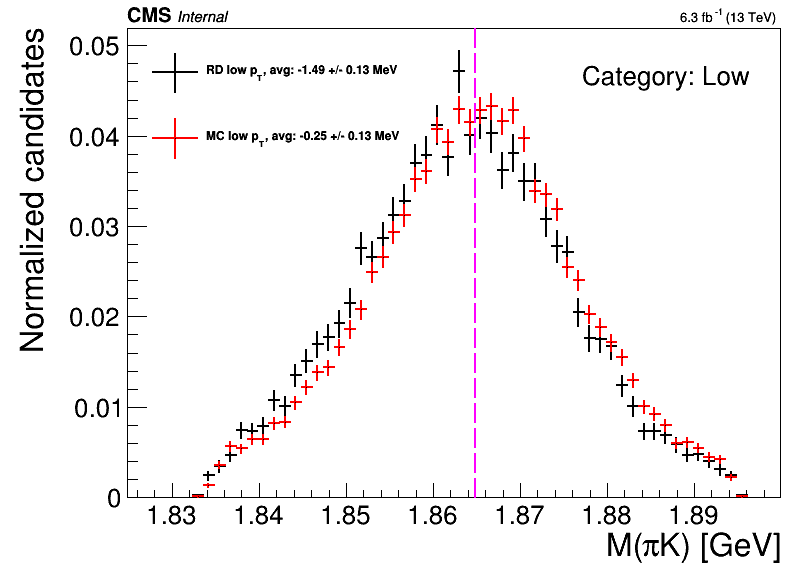

In [115]:
leg = rt.TLegend(0.18, 0.7, 0.5, 0.93)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
h_list=[]

selRD = np.logical_and(df['pi_pt']<cPi, df['K_pt']<cK)
h = create_TH1D(df['mass_piK'][selRD], name='RDlow',
                binning=[60, m_D0-0.04, m_D0+0.035], 
                axis_title=['M(#piK) [GeV]', 'Normalized candidates'],
                scale_histo='norm',
                opt='overflow+underflow'
               )
m = 1e3*(np.mean(df['mass_piK'][selRD])-m_D0)
s = 1e3*np.std(df['mass_piK'][selRD])
leg.AddEntry(h, 'RD low p_{{T}}, avg: {:.2f} +/- {:.2f} MeV'.format(m, s/np.sqrt(np.sum(selRD))), 'lep')
h_list.append(h)

selMC = np.logical_and(df_MC['pi_pt']<cPi, df_MC['K_pt']<cK)
h = create_TH1D(df_MC['mass_piK'][selMC], name='MClow',
                binning=h.binning, scale_histo='norm', opt='overflow+underflow')
h.SetLineColor(2)
m = 1e3*(np.mean(df_MC['mass_piK'][selMC])-m_D0)
s = 1e3*np.std(df_MC['mass_piK'][selMC])
leg.AddEntry(h, 'MC low p_{{T}}, avg: {:.2f} +/- {:.2f} MeV'.format(m, s/np.sqrt(np.sum(selRD))), 'lep')
h_list.append(h)


m = SetMaxToMaxHist(h_list)
c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
h.Sumw2()
leg.Draw()
cl.DrawLine(m_D0, 0, m_D0, m)

<ROOT.TLine object ("TLine") at 0xb341a40>

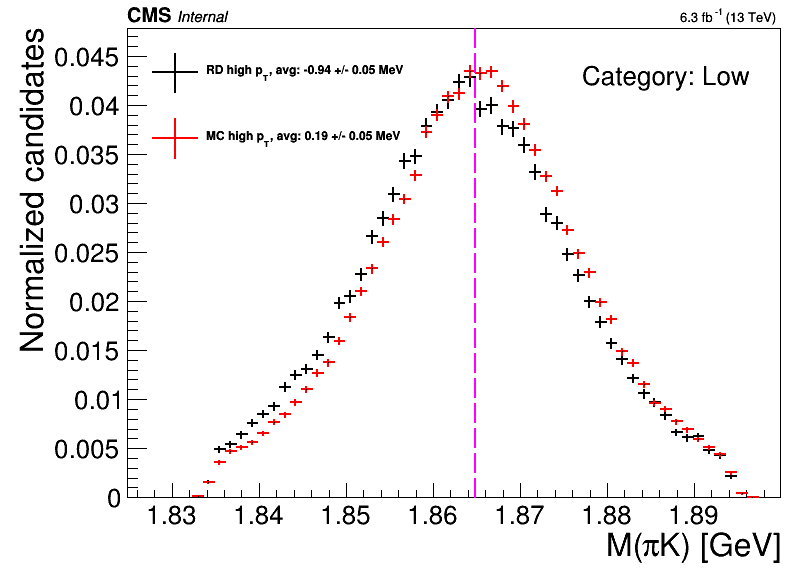

In [113]:
leg = rt.TLegend(0.18, 0.7, 0.5, 0.93)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
h_list=[]

selRD = np.logical_and(df['pi_pt']>cPi, df['K_pt']>cK)
h = create_TH1D(df['mass_piK'][selRD], name='RDlow',
                binning=[60, m_D0-0.04, m_D0+0.035], 
                axis_title=['M(#piK) [GeV]', 'Normalized candidates'],
                scale_histo='norm',
                opt='overflow+underflow'
               )
m = 1e3*(np.mean(df['mass_piK'][selRD])-m_D0)
s = 1e3*np.std(df['mass_piK'][selRD])
leg.AddEntry(h, 'RD high p_{{T}}, avg: {:.2f} +/- {:.2f} MeV'.format(m, s/np.sqrt(np.sum(selRD))), 'lep')
h_list.append(h)

selMC = np.logical_and(df_MC['pi_pt']>cPi, df_MC['K_pt']>cK)
h = create_TH1D(df_MC['mass_piK'][selMC], name='MClow',
                binning=h.binning, scale_histo='norm', opt='overflow+underflow')
h.SetLineColor(2)
m = 1e3*(np.mean(df_MC['mass_piK'][selMC])-m_D0)
s = 1e3*np.std(df_MC['mass_piK'][selMC])
leg.AddEntry(h, 'MC high p_{{T}}, avg: {:.2f} +/- {:.2f} MeV'.format(m, s/np.sqrt(np.sum(selRD))), 'lep')
h_list.append(h)


m = SetMaxToMaxHist(h_list)
c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
h.Sumw2()
leg.Draw()
cl.DrawLine(m_D0, 0, m_D0, m)

In [150]:
def getAvg(mass):
    m = np.mean(mass)
    s = np.std(mass)
    return [m, s/np.sqrt(mass.shape[0])]

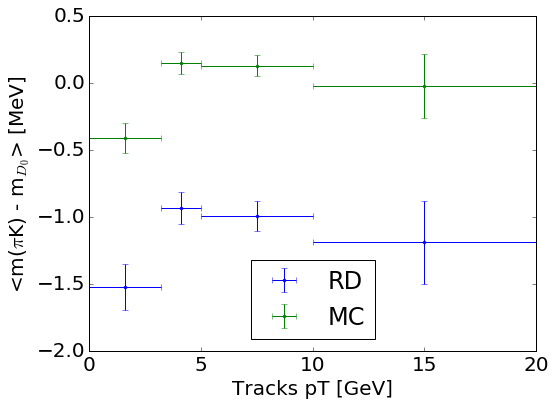

In [163]:
binsPt = np.array([0, 3.2, 5, 10, 20])
avgRD = []
avgMC = []

for i in range(len(binsPt)-1):
    mpt = binsPt[i]
    Mpt = binsPt[i+1]
    selm = np.logical_and(df['pi_pt']>mpt, df['K_pt']>mpt)
    selM = np.logical_and(df['pi_pt']<Mpt, df['K_pt']<Mpt)    
    selRD = np.logical_and(selm, selM)
    avgRD.append(getAvg(df['mass_piK'][selRD]))
    
    selm = np.logical_and(df_MC['pi_pt']>mpt, df_MC['K_pt']>mpt)
    selM = np.logical_and(df_MC['pi_pt']<Mpt, df_MC['K_pt']<Mpt)    
    selMC = np.logical_and(selm, selM)
    avgMC.append(getAvg(df_MC['mass_piK'][selMC]))

avgRD = 1e3*np.array(avgRD)
avgMC = 1e3*np.array(avgMC)

x = (binsPt[1:] + binsPt[:-1])/2.
dx = (binsPt[1:] - binsPt[:-1])/2.
plt.rcParams.update({'font.size': 20})
f = plt.figure(figsize=(8,6))
plt.errorbar(x, avgRD[:,0]-1e3*m_D0, yerr=avgRD[:,1], xerr=dx, fmt='.', label='RD')
plt.errorbar(x, avgMC[:,0]-1e3*m_D0, yerr=avgMC[:,1], xerr=dx, fmt='.', label='MC')
plt.legend(loc='best', numpoints=1)
plt.xlabel('Tracks pT [GeV]')
plt.ylabel('<m($\pi$K) - m$_{D_0}$> [MeV]')

In [176]:
x = np.column_stack((df_MC['pi_pt'], df_MC['pi_pt']-df_MC['MC_pi_pt']))
h2 = create_TH2D(x, binning=[7, 0, 20, 30, -0.1, 0.1])
C = drawOnCMSCanvas(CMS_lumi, [h2], ['colz'], tag='tl', mL=0.22, mR=0.18, mB=0.18)

KeyError: 'MC_pi_pt'

<ROOT.TLine object ("TLine") at 0xcf377a0>

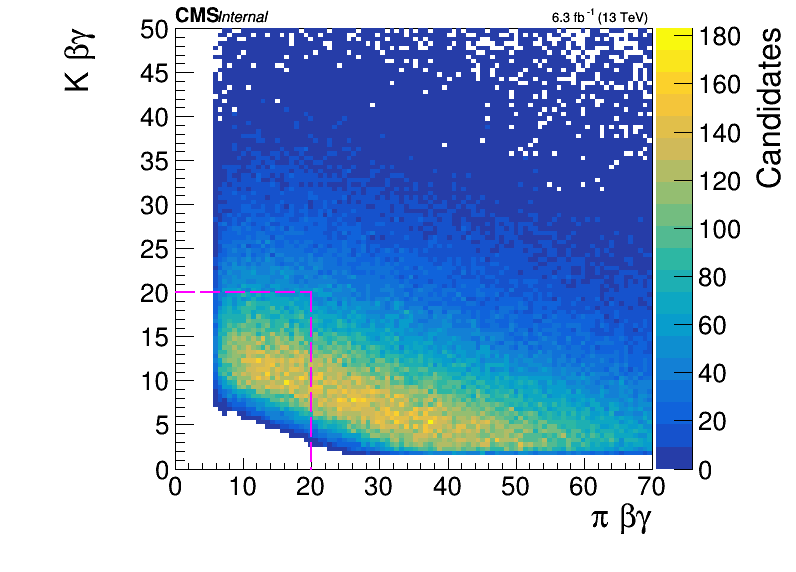

In [70]:
bgMC = np.column_stack((df_MC['pi_pt']*np.cosh(df_MC['pi_eta'])/m_pi, df_MC['K_pt']*np.cosh(df_MC['K_eta'])/m_K))
h2 = create_TH2D(bgMC, name='h_betaG',
                 binning=[100,0,70,100,0,50],
                 axis_title=['#pi #beta#gamma', 'K #beta#gamma', 'Candidates']
                )
CC = drawOnCMSCanvas(CMS_lumi, [h2], ['colz'], tag='tl', mL=0.22, mR=0.18, mB=0.18)
cPi = 20.
cK=20.
cl.DrawLine(0,cK,cPi,cK)
cl.DrawLine(cPi,0,cPi,cK)

<ROOT.TLine object ("TLine") at 0xd2f9070>

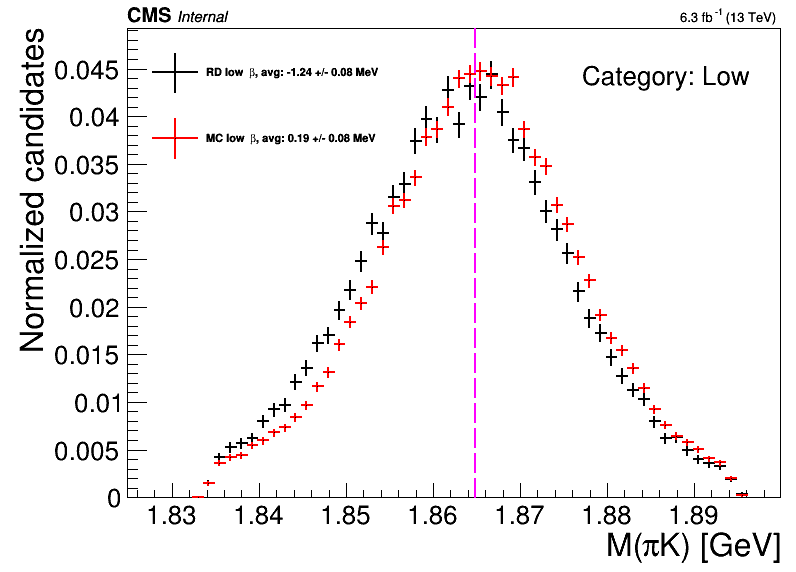

In [105]:
leg = rt.TLegend(0.18, 0.7, 0.5, 0.93)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
h_list=[]

bgRD = np.column_stack((df['pi_pt']*np.cosh(df['pi_eta'])/m_pi, df['K_pt']*np.cosh(df['K_eta'])/m_K))
selRD = np.logical_and(bgRD[:,0]<cPi, bgRD[:,1]<cK)
h = create_TH1D(df['mass_piK'][selRD], name='RDlow',
                binning=[60, m_D0-0.04, m_D0+0.035], 
                axis_title=['M(#piK) [GeV]', 'Normalized candidates'],
                scale_histo='norm',
                opt='overflow+underflow'
               )
m = 1e3*(np.mean(df['mass_piK'][selRD])-m_D0)
s = 1e3*np.std(df['mass_piK'][selRD])
leg.AddEntry(h, 'RD low #beta, avg: {:.2f} +/- {:.2f} MeV'.format(m, s/np.sqrt(np.sum(selRD))), 'lep')
h_list.append(h)

selMC = np.logical_and(bgMC[:,0]<cPi, bgMC[:,1]<cK)
h = create_TH1D(df_MC['mass_piK'][selMC], name='MClow',
                binning=h.binning, scale_histo='norm', opt='overflow+underflow')
h.SetLineColor(2)
m = 1e3*(np.mean(df_MC['mass_piK'][selMC])-m_D0)
s = 1e3*np.std(df_MC['mass_piK'][selMC])
leg.AddEntry(h, 'MC low #beta, avg: {:.2f} +/- {:.2f} MeV'.format(m, s/np.sqrt(np.sum(selRD))), 'lep')
h_list.append(h)


m = SetMaxToMaxHist(h_list)
c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
h.Sumw2()
leg.Draw()
cl.DrawLine(m_D0, 0, m_D0, m)

<ROOT.TLine object ("TLine") at 0xedc3040>

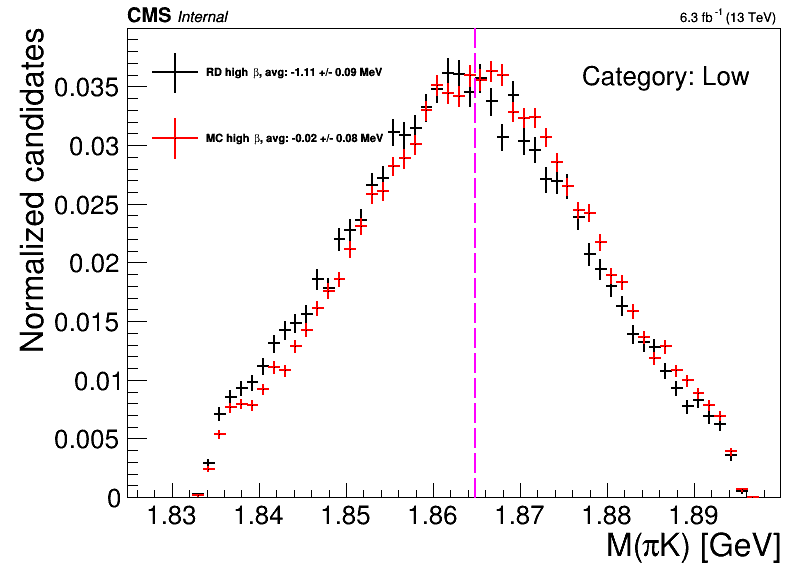

In [106]:
leg = rt.TLegend(0.18, 0.7, 0.5, 0.93)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
h_list=[]

selRD = np.logical_and(bgRD[:,0]>cPi, bgRD[:,1]>cK)
h = create_TH1D(df['mass_piK'][selRD], name='RDlow',
                binning=[60, m_D0-0.04, m_D0+0.035], 
                axis_title=['M(#piK) [GeV]', 'Normalized candidates'],
                scale_histo='norm',
                opt='overflow+underflow'
               )
m = 1e3*(np.mean(df['mass_piK'][selRD])-m_D0)
s = 1e3*np.std(df['mass_piK'][selRD])
leg.AddEntry(h, 'RD high #beta, avg: {:.2f} +/- {:.2f} MeV'.format(m, s/np.sqrt(np.sum(selRD))), 'lep')
h_list.append(h)

selMC = np.logical_and(bgMC[:,0]>cPi, bgMC[:,1]>cK)
h = create_TH1D(df_MC['mass_piK'][selMC], name='MClow',
                binning=h.binning, scale_histo='norm', opt='overflow+underflow')
h.SetLineColor(2)
m = 1e3*(np.mean(df_MC['mass_piK'][selMC])-m_D0)
s = 1e3*np.std(df_MC['mass_piK'][selMC])
leg.AddEntry(h, 'MC high #beta, avg: {:.2f} +/- {:.2f} MeV'.format(m, s/np.sqrt(np.sum(selRD))), 'lep')
h_list.append(h)


m = SetMaxToMaxHist(h_list)
c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
h.Sumw2()
leg.Draw()
cl.DrawLine(m_D0, 0, m_D0, m)

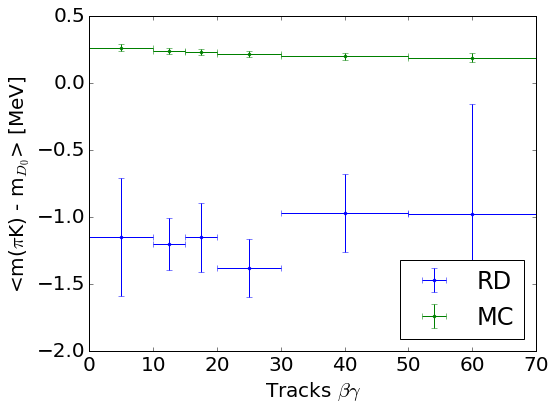

In [170]:
bgMC = np.column_stack((df_MC['pi_pt']*np.cosh(df_MC['pi_eta'])/m_pi, df_MC['K_pt']*np.cosh(df_MC['K_eta'])/m_K))
bgRD = np.column_stack((df['pi_pt']*np.cosh(df['pi_eta'])/m_pi, df['K_pt']*np.cosh(df['K_eta'])/m_K))

binsBG = np.array([0, 10, 15, 20, 30, 50, 70])
avgRD = []
avgMC = []

for i in range(len(binsBG)-1):
    m = binsBG[i]
    M = binsBG[i+1]
    selm = np.logical_and(bgRD[:,0]>m, bgRD[:,1]>m)
    selM = np.logical_and(bgRD[:,0]<M, bgRD[:,1]<M)    
    selRD = np.logical_and(selm, selM)
    avgRD.append(getAvg(df['mass_piK'][selRD]))
    
    selm = np.logical_and(bgMC[:,0]>m, bgMC[:,0]>m)
    selM = np.logical_and(bgMC[:,1]<M, bgMC[:,1]<M)    
    selMC = np.logical_and(selm, selM)
    avgMC.append(getAvg(df_MC['mass_piK'][selMC]))

avgRD = 1e3*np.array(avgRD)
avgMC = 1e3*np.array(avgMC)

x = (binsBG[1:] + binsBG[:-1])/2.
dx = (binsBG[1:] - binsBG[:-1])/2.
plt.rcParams.update({'font.size': 20})
f = plt.figure(figsize=(8,6))
plt.errorbar(x, avgRD[:,0]-1e3*m_D0, yerr=avgRD[:,1], xerr=dx, fmt='.', label='RD')
plt.errorbar(x, avgMC[:,0]-1e3*m_D0, yerr=avgMC[:,1], xerr=dx, fmt='.', label='MC')
plt.legend(loc='best', numpoints=1)
plt.xlabel(r'Tracks $\beta \gamma$')
plt.ylabel('<m($\pi$K) - m$_{D_0}$> [MeV]')

Eff: 15.0%


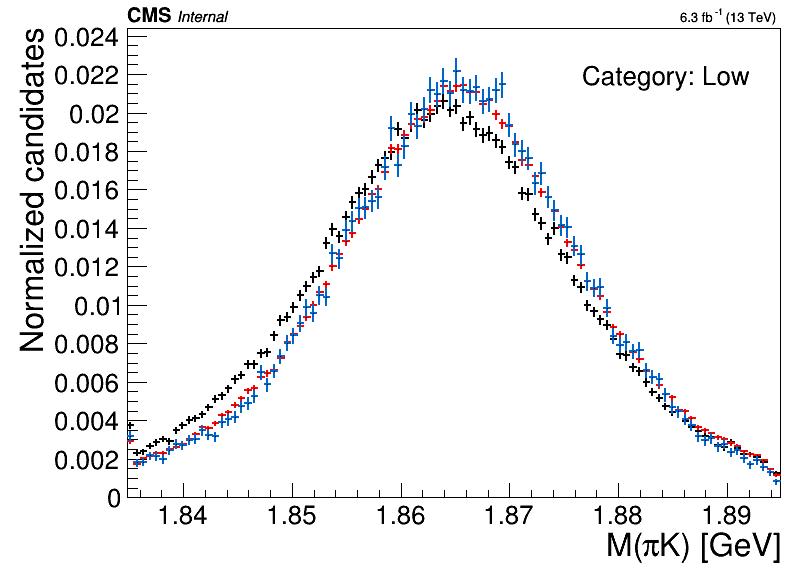

In [68]:
sel=np.logical_and(bg[:,0]<cPi, bg[:,1]<cK).astype(np.float)
print 'Eff: {:.1f}%'.format(100*np.sum(sel)/float(sel.shape[0]))
C = drawVar('mass_piK', [100, m_D0-0.03, m_D0+0.03], 'M(#piK) [GeV]', weights=sel)

Eff: 14.0%


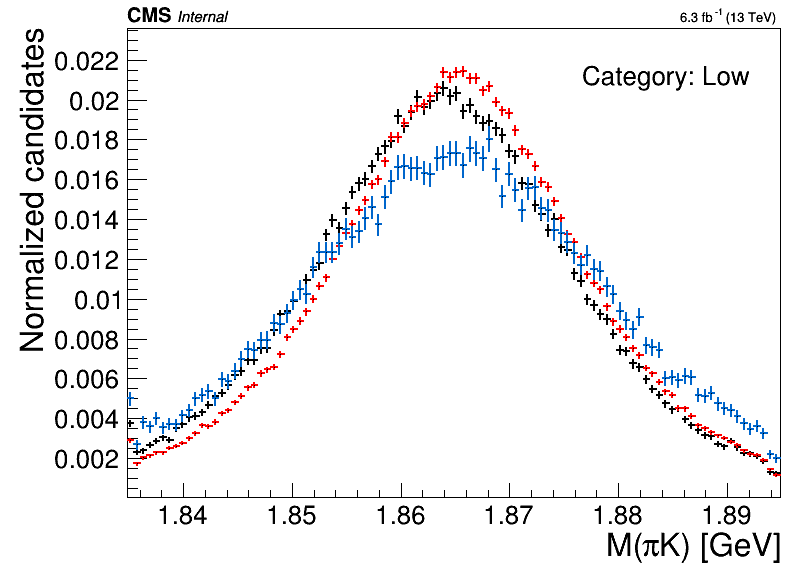

In [69]:
sel=np.logical_and(bg[:,0]>cPi, bg[:,1]>cK).astype(np.float)
print 'Eff: {:.1f}%'.format(100*np.sum(sel)/float(sel.shape[0]))
C = drawVar('mass_piK', [100, m_D0-0.03, m_D0+0.03], 'M(#piK) [GeV]', weights=sel)

# D* observables

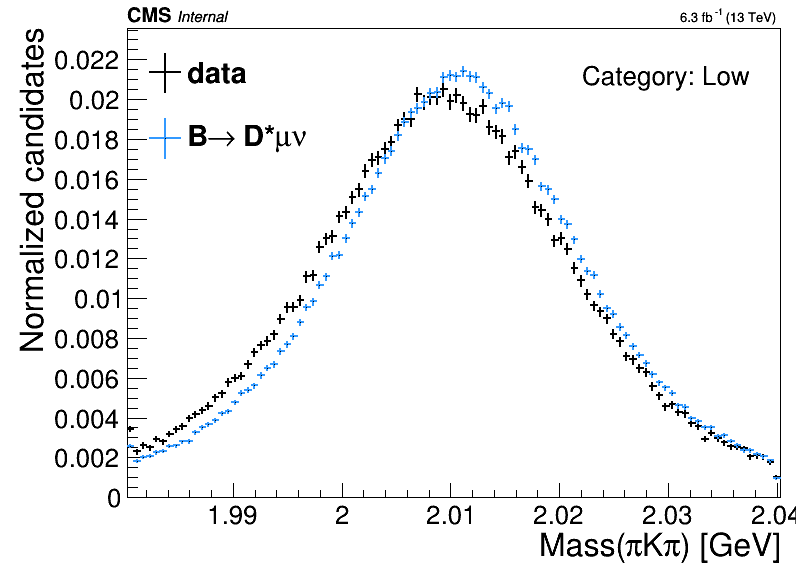

In [143]:
C = drawVar('mass_D0pis', [100, m_Dst-0.03, m_Dst+0.03], 'Mass(#piK#pi) [GeV]')

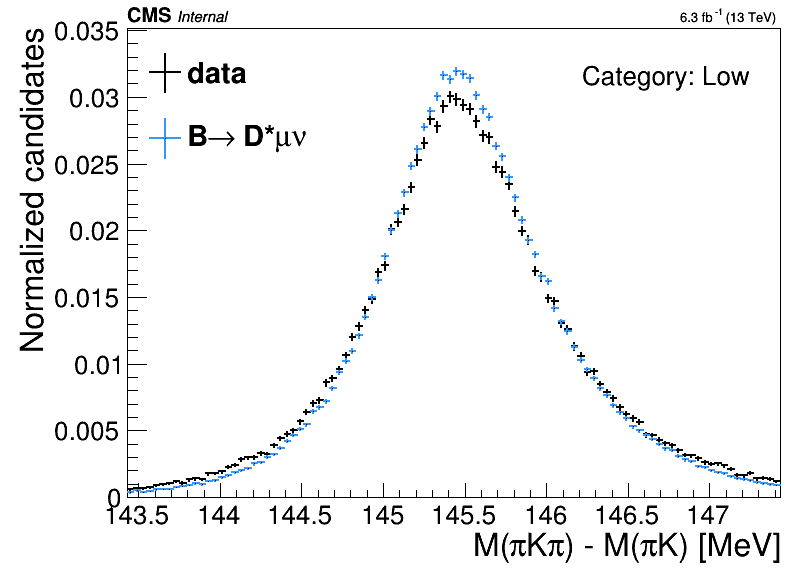

In [142]:
C = drawVar([1e3*dM, 1e3*dM_MC], [100, 1e3*dm - 2, 1e3*dm + 2], 'M(#piK#pi) - M(#piK) [MeV]')

# Fit

In [ ]:
def getInputs(n):
#     aeta = np.abs(df_MC[n + '_eta'])
    eta = df_MC[n + '_eta']
    pt = df_MC[n + '_pt']
    return np.column_stack((1./pt, pt, eta, pt*eta, np.square(pt), np.square(eta)))

In [ ]:
def getEventsWeights(p):
    w = p[0] + np.sum(p[1:]*getInputs('pi'), axis=1)
    w *= p[0] + np.sum(p[1:]*getInputs('K'), axis=1)
    w *= p[0] + np.sum(p[1:]*getInputs('pis'), axis=1)
    return w

In [ ]:
from scipy.optimize import minimize

In [ ]:
yd_piK, _ = np.histogram(df['mass_piK'], 100, (m_D0-0.03, m_D0+0.03))
nTot = float(np.sum(yd_piK))
ed_piK = np.sqrt(yd_piK)/nTot
yd_piK = yd_piK/nTot

def chi2_piK(w):
    ys, _ = np.histogram(df_MC['mass_piK'], 100, (m_D0-0.03, m_D0+0.03), weights=w)
    nTot = float(np.sum(ys))
    ys = ys/nTot
    
    chi2 = np.square((yd_piK - ys)/ed_piK)
    return np.sum(chi2)

In [ ]:
yd_piPt, _ = np.histogram(df['pi_pt'], 100, (0.8, 20))
nTot = float(np.sum(yd_piPt))
ed_piPt = np.sqrt(yd_piPt)/nTot
yd_piPt = yd_piPt/nTot

def chi2_piPt(w):
    ys, _ = np.histogram(df_MC['pi_pt'], 100, (0.8, 20), weights=w)
    nTot = float(np.sum(ys))
    ys = ys/nTot
    
    chi2 = np.square((yd_piPt - ys)/ed_piPt)
    return np.sum(chi2)

In [ ]:
yd_piEta, _ = np.histogram(df['pi_eta'], 100, (-2, 2))
nTot = float(np.sum(yd_piEta))
ed_piEta = np.sqrt(yd_piEta)/nTot
yd_piEta = yd_piEta/nTot

def chi2_piEta(w):
    ys, _ = np.histogram(df_MC['pi_eta'], 100, (-2, 2), weights=w)
    nTot = float(np.sum(ys))
    ys = ys/nTot
    
    chi2 = np.square((yd_piEta - ys)/ed_piEta)
    return np.sum(chi2)

In [ ]:
def fTarget(p):
    w = getEventsWeights(p)
    pen = np.sum(np.square(1-w))
    pen += np.sum(w<0)**2
    return chi2_piK(w) + chi2_piPt(w) + chi2_piEta(w) + 0.001*pen

In [ ]:
x0 = np.array([1,0,0,0,0,0,0])
print 'Start loss: {:.1f}'.format(fTarget(x0))
res = minimize(fTarget, x0, tol=1e-2)
print 'End loss: {:.1f} ({:.1f})'.format(res.fun, res.fun/100.)
print 'Optimal par:', res.x

In [ ]:
w = getEventsWeights(res.x)
plt.hist(w, bins=50, range=(np.percentile(w, 100*(1e-4)), np.percentile(w, 100*(1-1e-4))))
plt.yscale('log')

In [ ]:
C = drawVar('mass_piK', [100, m_D0-0.03, m_D0+0.03], 'M(#piK) [GeV]', weights=w)

In [ ]:
C = drawVar('pi_pt', [100, 0.8, 20], '#pi p_{T} [GeV]', weights=w)

In [ ]:
C = drawVar('pi_eta', [100, -2.2, 2.2], '#pi #eta [GeV]', weights=w)